# Quantum Circuits
Quantum computers can only use a specific set of gates (universal gate set). Given the entanglers and their amplitudes found in Step 3, one can find corresponding representation of these operators in terms of elementary gates using the following procedure.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

import tequila as tq
from utility import *

First, we set up the Hamiltonian in Tequila's format and the unitary gates obtained in Step 3. 

In [2]:
H = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian('h2', 2, 'sto-3g', qubit_transf='jw'))
a = tq.Variable("tau_0")
U = construct_QMF_ansatz(4)
U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(0)Y(1)X(2)X(3)"), angle=a)
print(U)

circuit: 
Rx(target=(0,), parameter=beta_0)
Rz(target=(0,), parameter=gamma_0)
Rx(target=(1,), parameter=beta_1)
Rz(target=(1,), parameter=gamma_1)
Rx(target=(2,), parameter=beta_2)
Rz(target=(2,), parameter=gamma_2)
Rx(target=(3,), parameter=beta_3)
Rz(target=(3,), parameter=gamma_3)
Exp-Pauli(target=(0, 1, 2, 3), control=(), parameter=tau_0, paulistring=X(0)Y(1)X(2)X(3))



One can check the expectation value to see it is near the ground state energy.

In [13]:
E = tq.ExpectationValue(H=H, U=U)
vars = {'beta_1': 3.141592624143881, 'beta_0': 3.141592624143881, 'tau_0': 1.1331410014096885, 'gamma_1': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'gamma_2': 0.0, 'gamma_0': 0.0, 'beta_2': 0.0} # values obtained from step 3
print(tq.simulate(E, variables=vars))

-0.9486411121761622


In [14]:
print(vars)

{'beta_1': 3.141592624143881, 'beta_0': 3.141592624143881, 'tau_0': 1.1331410014096885, 'gamma_1': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'gamma_2': 0.0, 'gamma_0': 0.0, 'beta_2': 0.0}


One can run the same experiment on a real quantum computer through IBM Quantum Experience (ibmq). After activating your account here (https://quantum-computing.ibm.com/login), copy the API token and execute the commented block below. 

In [4]:
from qiskit import IBMQ
IBMQ.save_account('f861f8d4980810e76f8db0e01272f74ca7f705bdcacd2bfbffb2dd9178f5e7a5d581ca2623cb70ac75bfbfc5d91b5ba7ea40fb6f3134585846fb828c45913f35')

configrc.store_credentials:WARNING:2021-07-22 18:57:40,924: Credentials already present. Set overwrite=True to overwrite.


In [4]:
# list of devices available can be found in ibmq account page
# Try a device that isn't too busy. If the wait time is too long, measure only one pauli-word in the H2 Hamilotonian using the commented line
E = tq.ExpectationValue(H=tq.QubitHamiltonian.from_paulistrings("X(0)X(1)Y(2)Y(3)"), U=U)
#tq.simulate(E, variables=vars, samples=100, backend="qiskit", device='ibmq_bogota')

AttributeError: 'str' object has no attribute 'key_openfermion'

In [4]:
tq.simulate(E, variables=vars, samples=100, backend="qiskit", device='ibmq_belem')

-0.6782390850939107

In [6]:
tq.simulate(E, variables=vars, samples=1000, backend="qiskit", device='ibmq_belem')

-0.7031310116153874

In [7]:
tq.simulate(E, variables=vars, samples=5000, backend="qiskit", device='ibmq_belem')

-0.7047891180121715

In [9]:
tq.simulate(E, variables=vars, samples=8192, backend="qiskit", device='ibmq_belem')

-0.6854283267691902

In [23]:
Ebins = np.zeros(20)
for bin in range(len(Ebins)):
    Ebins[bin] = tq.simulate(E, variables=vars, samples=1000, backend="qiskit", device='ibmq_belem')

In [26]:
print(Ebins)
print('Average Energy:',np.average(Ebins))
print('Stdev: ',np.std(Ebins))

[-0.72075524 -0.70971011 -0.69059255 -0.6739535  -0.69294476 -0.69786041
 -0.68731566 -0.69082685 -0.69879121 -0.69856461 -0.71185924 -0.68033561
 -0.64666273 -0.70124051 -0.6844145  -0.69290368 -0.66140423 -0.71572174
 -0.67042917 -0.69995236]
Average Energy: -0.6913119333609608
Stdev:  0.017837450929769186


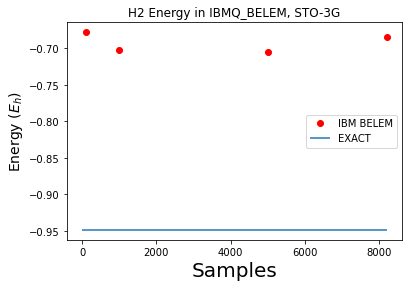

In [30]:
import matplotlib.pyplot as plt

samples = [100,1000,5000,8192]
Evals = [-0.6782390850939107, -0.7031310116153874, -0.7047891180121715, -0.6854283267691902]
plt.plot(samples,Evals,'or',label='IBM BELEM')
plt.hlines(-0.9486411121761622,0,8192,label='EXACT')

plt.title('H2 Energy in IBMQ_BELEM, STO-3G')
plt.xlabel('Samples',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)
plt.legend(loc='center right')

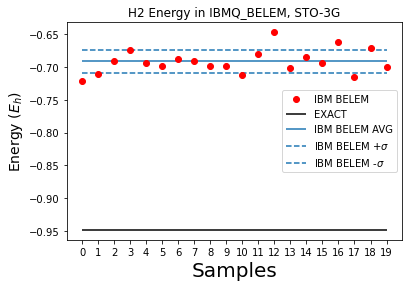

In [37]:
import matplotlib.pyplot as plt

samples = [100,1000,5000,8192]
Evals = [-0.6782390850939107, -0.7031310116153874, -0.7047891180121715, -0.6854283267691902]
plt.plot(range(len(Ebins)),Ebins,'or',label='IBM BELEM')
plt.hlines(-0.9486411121761622,0,19,label='EXACT',colors='black')
plt.hlines(np.average(Ebins),0,19,label='IBM BELEM AVG')
plt.hlines(np.average(Ebins)+np.std(Ebins),0,19,label=r'IBM BELEM +$\sigma$',linestyles='dashed')
plt.hlines(np.average(Ebins)-np.std(Ebins),0,19,label=r'IBM BELEM -$\sigma$',linestyles='dashed')

plt.title('H2 Energy in IBMQ_BELEM, STO-3G')
plt.xlabel('Samples',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)
plt.xticks(range(len(Ebins)))
plt.legend(loc='center right')

The following code block prints the circuit.

In [5]:
circ = tq.circuit.compiler.compile_exponential_pauli_gate(U)
tq.draw(circ, backend="qiskit")

┌────────────────────┐┌─────────────────────┐┌──────────┐               »
q_0: ┤ Rx(f((beta_0,))_0) ├┤ Rz(f((gamma_0,))_1) ├┤ Ry(-π/2) ├──■────────────»
     ├────────────────────┤├─────────────────────┤├─────────┬┘┌─┴─┐          »
q_1: ┤ Rx(f((beta_1,))_2) ├┤ Rz(f((gamma_1,))_3) ├┤ Rx(π/2) ├─┤ X ├──■───────»
     ├────────────────────┤├─────────────────────┤├─────────┴┐└───┘┌─┴─┐     »
q_2: ┤ Rx(f((beta_2,))_4) ├┤ Rz(f((gamma_2,))_5) ├┤ Ry(-π/2) ├─────┤ X ├──■──»
     ├────────────────────┤├─────────────────────┤├──────────┤     └───┘┌─┴─┐»
q_3: ┤ Rx(f((beta_3,))_6) ├┤ Rz(f((gamma_3,))_7) ├┤ Ry(-π/2) ├──────────┤ X ├»
     └────────────────────┘└─────────────────────┘└──────────┘          └───┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                     ┌─────────┐ 
«q_0: ──────────────────────────────────────────■─────┤ Ry(π/2) ├─
«                                             ┌─┴─┐   ├─────────┴┐
«q_1: ───────────────────────────────■────────┤ X ├───┤ Rx(-π/2) ├
«                                  ┌─┴─┐   ┌──┴───┴──┐└──────────┘
«q_2: ───────────────────────■─────┤ X ├───┤ Ry(π/2) ├────────────
«     ┌───────────────────┐┌─┴─┐┌──┴───┴──┐└─────────┘            
«q_3: ┤ Rz(f((tau_0,))_8) ├┤ X ├┤ Ry(π/2) ├───────────────────────
«     └───────────────────┘└───┘└─────────┘                       
«c: 4/════════════════════════════════════════════════════════════
«